In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as pl
from pprint import pprint
import collections
import itertools
import random

pl.rcParams['figure.figsize'] = [20, 20]

In [2]:
g = nx.read_graphml('all.graphml')
# convert from digraph to undirected
if g.is_directed():
    g = g.to_undirected()
# convert from multigraph to standard graph
g = nx.Graph(g)

nodes = g.nodes(data=True)
edges = g.edges()
info = nx.info(g)
print(info)
nodes = {k: v for k, v in nodes}
edges = tuple((k, v) for k, v in edges)
fname = 'cluster'
fcon = 'right'
flib = 'left'
fcen = '-'
con = [k for k, v in nodes.items() if v[fname] == fcon]
lib = [k for k, v in nodes.items() if v[fname] == flib]
cen = [k for k, v in nodes.items() if v[fname] == fcen]
pprint(dict(con=len(con), lib=len(lib), cen=len(cen), total=(len(con) + len(lib) + len(cen))))

Name: 
Type: Graph
Number of nodes: 22405
Number of edges: 59926
Average degree:   5.3493
{'cen': 3935, 'con': 7115, 'lib': 11355, 'total': 22405}


In [3]:
# calc modularity of network
from networkx.algorithms.community.quality import modularity
q =  modularity(g, [con, lib, cen])

pprint(dict(modularity=q))

{'modularity': 0.4174746807148323}


In [4]:
esample = random.sample(edges, 25)
#print("Edge Sample:")
#pprint(esample)

nsample = {flib: {}, fcon: {}, fcen: {}}
for u, v in esample:
    uclust = g.nodes[u][fname]
    vclust = g.nodes[v][fname]
    if u not in nsample[uclust]:
        nsample[uclust][u] = tuple(g.neighbors(u))
    if v not in nsample[vclust]:
        nsample[vclust][v] = tuple(g.neighbors(v))

#print("Nodes from Edges Sample:")
#pprint(nsample, depth=2)

In [5]:
def get_cluster(graph, node, field='cluster'):
    """
    getter for cluster value of node in graph.
    """
    if node in graph.nodes and field in graph.nodes[node]:
        return graph.nodes[node][field]
    print(f'missing cluster for node "{node}", values: {graph.nodes[node]}')
    raise KeyError(field)


def ratio_calc(graph, node, s=1, o=0, n=0.5,
               field='cluster', neutral='-', right='right', left='left', 
               no_neighbor_value=None, no_alignment_value=None):
    """
    Perform a ratio calculation on given node in graph.
    
    ratio = (s * Ns + o * No + n * Nn) / N
    
    Where:
        Ns, No, Nn, and N are number of neighbors that are the same, other, neutral, and total (resp).
        s, o, and n are tuning parameters for same, other, and neutral (resp).
    """
    nbors = tuple(graph.neighbors(node))
    nclust = get_cluster(graph, node, field)
    
    if nclust == neutral:
        return no_alignment_value
    if 0 == len(nbors):
        return no_neighbor_value
    
    nother = right if nclust == left else left
    counts = { k: float(len(list(v))) for k,v in itertools.groupby(nbors, key=lambda y: get_cluster(graph, y, field)) }
    ratio = ((s * counts.get(nclust, 0)) + (o * counts.get(nother, 0)) + (n * counts.get(neutral, 0))) \
                / len(nbors)
    return ratio

ratios = { n: ratio_calc(g, n) for n in g.nodes() }
ratios = { k: v for k, v in ratios.items() if v }

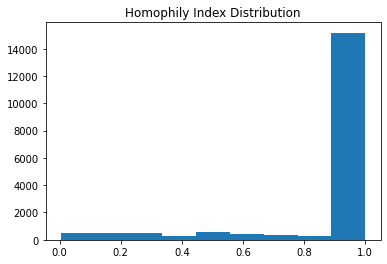

See also differences between mention and retweet distributions.
Retweet bias overpowers nuance in mention network dissortative mixing.


In [6]:
d = { k: len(tuple(v)) for k, v in itertools.groupby(sorted(ratios.values())) }
#plot, (ap, bp) = pl.subplots(2)
#plot.suptitle('Combined Ratio Distribution')
#ap.scatter(d.keys(), d.values())
pl.title("Homophily Index Distribution")
pl.hist(ratios.values(), bins=9)
pl.show()

print("See also differences between mention and retweet distributions.")
print("Retweet bias overpowers nuance in mention network dissortative mixing.")

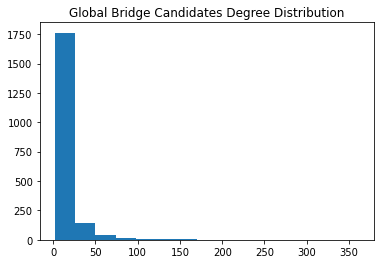

In [7]:
bridge_min = .25
bridge_max = .75

candidates = { k: len(list(g.neighbors(k))) for k, v in ratios.items() if bridge_min <= v <= bridge_max }

d = { k: len(tuple(v)) for k, v in itertools.groupby(candidates.items(), key=lambda y: y[1]) }
pl.plot()
pl.title('Global Bridge Candidates Degree Distribution')
pl.hist(candidates.values(), bins=15)
pl.show()

In [8]:
# we have some solid global candidates >50 degree
bridge_deg = 100

bridges = collections.OrderedDict()
for k, v in sorted(candidates.items(), key=lambda y: y[1], reverse=True):
    if v < bridge_deg:
        break
    bridges[k] = v
    
bridges_con = {k: v for k, v in bridges.items() if nodes[k][fname] == fcon}
bridges_lib = {k: v for k, v in bridges.items() if nodes[k][fname] == flib}

print("{} Bridge Candidates w/ Degree > {} [{}, {}]".format(len(bridges.items()), bridge_deg, bridge_min, bridge_max))
print("=====================================")
print(" node   deg  ratio  alignment")
print("-------------------------------------")
for k, v in bridges_con.items():
    print("{: <6}  {:3d}  {:.2f} {}".format(k, v, ratios[k], nodes[k][fname]))
print()
for k, v in bridges_lib.items():
    print("{: <6}  {:3d}  {:.2f} {}".format(k, v, ratios[k], nodes[k][fname]))

24 Bridge Candidates w/ Degree > 100 [0.25, 0.75]
 node   deg  ratio  alignment
-------------------------------------
n11956  362  0.31 right
n11738  252  0.43 right
n7395   180  0.30 right
n5606   171  0.36 right
n11139  165  0.45 right
n17573  147  0.27 right
n22096  146  0.32 right
n2831   145  0.29 right
n19343  130  0.65 right
n14351  129  0.60 right
n11961  124  0.33 right
n9254   123  0.43 right
n17640  121  0.32 right
n1735   120  0.57 right
n6715   117  0.33 right
n3870   111  0.35 right

n6047   212  0.44 left
n14357  153  0.41 left
n21567  140  0.49 left
n6123   120  0.28 left
n12049  119  0.67 left
n3790   115  0.30 left
n8262   113  0.43 left
n7472   109  0.34 left


In [9]:
samples_threshold = .75
samples = { k: v for k, v in ratios.items() if v > samples_threshold and g.nodes[k][fname] != fcen }
#samples = dict(random.sample(samples.items(), 100))

In [10]:
def recommend_links(graph, u, uratio, fn='cluster', none_value='-', none_weight=0.33, cutoff=2):
    results = {}
    cluster = graph.nodes[u][fn]
    nearby = { n: l for n, l in nx.single_source_shortest_path_length(graph, u, cutoff=cutoff).items() if l > 1 }
    unbors = set(graph.neighbors(u))
    for v, dist in nearby.items():
        vcluster = graph.nodes[v][fn]
        if vcluster != cluster:
            vnbors = set(graph.neighbors(v))
            shared = unbors & vnbors
            weight = none_weight if vcluster == none_value else 1
            score = weight / cutoff * max(1, len(shared))
            results[v] = (score, vcluster)
    return sorted(results.items(), key=lambda y: y[1][0], reverse=True)

def get_common_neighbors(graph, u, v):
    nu = set(graph.neighbors(u))
    nv = set(graph.neighbors(v))
    return nu & nv

def predict_common_neighbors(graph, u):
    nearby = { n: 0 for n, l in nx.single_source_shortest_path_length(graph, u, cutoff=2).items() if l > 1 }
    for v, _ in nearby.items():
        shared = get_common_neighbors(graph, u, v)
        nearby[v] = len(shared)
    return sorted(nearby.items(), key=lambda y: y[1], reverse=True)

def get_degree(graph, u):
    return len(list(graph.neighbors(u)))

In [11]:
bcon = [k for k, v in bridges_con.items() ]
blib = [k for k, v in bridges_lib.items() ]
experiment = True

if experiment:
    i = 0
    needed_bridge = []
    
    print(f'EXP: Processing {len(samples)} samples, printing every 500th record only...')
    for u, ratio in samples.items():
        r = recommend_links(g, u, ratios)
        c = g.nodes[u][fname]
        d = get_degree(g, u)
        if r:
            # select the highest
            r = r[0][0]
        else:
            # select a compatible bridge node at random 
            r = random.choice(blib if c == fcon else bcon)
            needed_bridge.append(u)

        g.add_edge(u, r)
        ratios[u] = ratio_calc(g, u)
        if fcen != g.nodes[r][fname]:
            ratios[r] = ratio_calc(g, r)
        
        if 0 == i % 500:
            pprint(dict(_i=i, _node=u, cluster=c, ratio_a=ratio, ratio_b=ratios[u], degree_a=d, degree_b=get_degree(g, u), recommended=r))
        i += 1

    print()
    print(f'{i} nodes processed. {len(needed_bridge)} nodes relied on bridge nodes.')

else:
    # perform common neighbor recommendation against a copy of g to produce a null reference
    failed_pred = []
    j = 0
    
    print(f'NUL: Processing {len(samples)} samples, printing every 500th record only...')
    for u, ratio in samples.items():
        d = get_degree(g, u)
        c = g.nodes[u][fname]
        res = predict_common_neighbors(g, u)
        if res:
            r = res[0][0]
        else:
            print(f'Cannot perform common neighbor prediction against node {u}.')
            failed_pred.append(u)
            continue
        
        try:
            g.add_edge(u, r)
            ratios[u] = ratio_calc(g, u)
            if fcen != g.nodes[r][fname]:
                ratios[r] = ratio_calc(g, r)
        except KeyError:
            print("errrrrrorrrrr", u, r, res)

        if 0 == j % 500:
            pprint(dict(_j=j, _node=u, cluster=c, ratio_a=ratio, ratio_b=ratios[u], degree_a=d, degree_b=get_degree(g, u), recommended=r))
        j += 1
        
    print()
    print(f'{j} nodes processed. {len(failed_pred)} yielded no recommendations to act on.')

EXP: Processing 15512 samples, printing every 500th record only...
{'_i': 0,
 '_node': 'n0',
 'cluster': 'right',
 'degree_a': 1,
 'degree_b': 2,
 'ratio_a': 1.0,
 'ratio_b': 0.5,
 'recommended': 'n14939'}
{'_i': 500,
 '_node': 'n680',
 'cluster': 'left',
 'degree_a': 1,
 'degree_b': 2,
 'ratio_a': 1.0,
 'ratio_b': 0.5,
 'recommended': 'n11961'}
{'_i': 1000,
 '_node': 'n1411',
 'cluster': 'right',
 'degree_a': 1,
 'degree_b': 2,
 'ratio_a': 1.0,
 'ratio_b': 0.5,
 'recommended': 'n14890'}
{'_i': 1500,
 '_node': 'n2114',
 'cluster': 'left',
 'degree_a': 2,
 'degree_b': 3,
 'ratio_a': 1.0,
 'ratio_b': 0.6666666666666666,
 'recommended': 'n14581'}
{'_i': 2000,
 '_node': 'n2842',
 'cluster': 'left',
 'degree_a': 1,
 'degree_b': 2,
 'ratio_a': 1.0,
 'ratio_b': 0.5,
 'recommended': 'n5830'}
{'_i': 2500,
 '_node': 'n3565',
 'cluster': 'left',
 'degree_a': 1,
 'degree_b': 2,
 'ratio_a': 1.0,
 'ratio_b': 0.5,
 'recommended': 'n1273'}
{'_i': 3000,
 '_node': 'n4305',
 'cluster': 'right',
 'degree_

[]


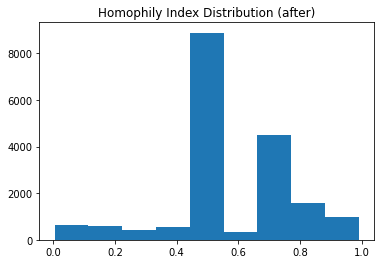

In [12]:
print([k for k, v in ratios.items() if type(v) == type(None)])
pl.title("Homophily Index Distribution (after)")
pl.hist(ratios.values(), bins=9)
pl.show()

In [13]:
q_bef = q
q_aft = modularity(g, [con, lib, cen])
pprint(dict(mod_a=q_bef, mod_b=q_aft))

{'mod_a': 0.4174746807148323, 'mod_b': 0.23614020567212873}
